In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the dataset (replace 'cscpopendata.csv' with your dataset path)
df = pd.read_csv('cscpopendata.csv')

# Display basic information and statistics about the dataset
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114635 entries, 0 to 114634
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  114635 non-null  int64  
 1   ProductName             114635 non-null  object 
 2   CSFId                   80662 non-null   float64
 3   CSF                     80237 non-null   object 
 4   CompanyId               114635 non-null  int64  
 5   CompanyName             114635 non-null  object 
 6   BrandName               114408 non-null  object 
 7   PrimaryCategoryId       114635 non-null  int64  
 8   PrimaryCategory         114635 non-null  object 
 9   SubCategoryId           114635 non-null  int64  
 10  SubCategory             114635 non-null  object 
 11  CasId                   114635 non-null  int64  
 12  CasNumber               108159 non-null  object 
 13  ChemicalId              114635 non-null  int64  
 14  ChemicalName        

,CDPHId,CSFId,CompanyId,PrimaryCategoryId,SubCategoryId,CasId,ChemicalId,ChemicalCount
count,114635.000000,80662.000000,114635.000000,114635.000000,114635.000000,114635.000000,114635.000000,114635.000000
mean,20304.858987,32608.658377,450.641532,51.076294,66.819252,674.094107,32837.556959,1.288359
std,12489.052554,19089.443910,409.533093,20.474341,35.822097,149.214101,20439.412299,0.636418
min,2.000000,1.000000,4.000000,1.000000,3.000000,2.000000,0.000000,0.000000
25%,8717.000000,15789.000000,86.000000,44.000000,48.000000,656.000000,13990.000000,1.000000
50%,20895.000000,32541.000000,297.000000,44.000000,52.000000,656.000000,32055.000000,1.000000
75%,31338.500000,48717.750000,798.000000,59.000000,65.000000,656.000000,51578.500000,1.000000
max,41524.000000,65009.000000,1391.000000,111.000000,172.000000,1242.000000,68074.000000,9.000000


In [2]:
# Drop columns with more than 50% missing values
df = df.dropna(axis=1, thresh=len(df) * 0.5)

# Fill remaining missing values: for numerical columns, use mean; for categorical columns, use mode
for column in df.columns:
    if df[column].dtype == 'object':
        # For categorical columns, fill with mode using .loc[]
        df.loc[:, column] = df[column].fillna(df[column].mode()[0])
    else:
        # For numerical columns, fill with mean using .loc[]
        df.loc[:, column] = df[column].fillna(df[column].mean())

# Verify the updated DataFrame for any remaining missing values
missing_values = df.isnull().sum()
print("Remaining missing values after cleaning:")
print(missing_values[missing_values > 0])


Remaining missing values after cleaning:
Series([], dtype: int64)


In [3]:
# Drop duplicate rows if they exist
df.drop_duplicates(inplace=True)

# Convert all string columns to lowercase for consistency
df = df.apply(lambda s: s.str.lower() if s.dtype == 'object' else s)

# Display the cleaned dataset info for verification
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 114378 entries, 0 to 114634
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  114378 non-null  int64  
 1   ProductName             114378 non-null  object 
 2   CSFId                   114378 non-null  float64
 3   CSF                     114378 non-null  object 
 4   CompanyId               114378 non-null  int64  
 5   CompanyName             114378 non-null  object 
 6   BrandName               114378 non-null  object 
 7   PrimaryCategoryId       114378 non-null  int64  
 8   PrimaryCategory         114378 non-null  object 
 9   SubCategoryId           114378 non-null  int64  
 10  SubCategory             114378 non-null  object 
 11  CasId                   114378 non-null  int64  
 12  CasNumber               114378 non-null  object 
 13  ChemicalId              114378 non-null  int64  
 14  ChemicalName            1

In [4]:
# Handling Outliers: Remove entries with z-score > 3 for numerical columns
from scipy import stats

# Compute Z-scores for numerical columns and filter out outliers
z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))
df = df[(z_scores < 3).all(axis=1)].copy()  # Create a copy to avoid the warning

# Convert date columns to datetime format using .loc[]
date_columns = ['InitialDateReported', 'MostRecentDateReported', 'DiscontinuedDate',
                'ChemicalCreatedAt', 'ChemicalUpdatedAt', 'ChemicalDateRemoved']

for col in date_columns:
    if col in df.columns:
        df.loc[:, col] = pd.to_datetime(df[col], errors='coerce')

# Display the updated DataFrame info after handling outliers and date conversion
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 108747 entries, 0 to 114634
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CDPHId                  108747 non-null  int64  
 1   ProductName             108747 non-null  object 
 2   CSFId                   108747 non-null  float64
 3   CSF                     108747 non-null  object 
 4   CompanyId               108747 non-null  int64  
 5   CompanyName             108747 non-null  object 
 6   BrandName               108747 non-null  object 
 7   PrimaryCategoryId       108747 non-null  int64  
 8   PrimaryCategory         108747 non-null  object 
 9   SubCategoryId           108747 non-null  int64  
 10  SubCategory             108747 non-null  object 
 11  CasId                   108747 non-null  int64  
 12  CasNumber               108747 non-null  object 
 13  ChemicalId              108747 non-null  int64  
 14  ChemicalName            1

In [5]:
from sklearn.preprocessing import LabelEncoder

# Select categorical columns with fewer unique categories for One-Hot Encoding
one_hot_columns = ['PrimaryCategory', 'SubCategory']
df = pd.get_dummies(df, columns=one_hot_columns)

# Use Label Encoding for columns with high cardinality
label_encoder_columns = ['BrandName', 'CSF', 'CompanyName']

for column in label_encoder_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Convert boolean columns to integers (0/1), if any exist
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

# Display updated DataFrame information to verify the encoding process
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 108747 entries, 0 to 114634
Columns: 120 entries, CDPHId to SubCategory_uv gel nail polish
dtypes: float64(1), int32(105), int64(7), object(7)
memory usage: 56.8+ MB


In [6]:
# Create a binary target column 'RiskFlag' in an optimized way to avoid fragmentation
df = df.copy()  # Create a copy to avoid fragmentation issues
df['RiskFlag'] = (df['ChemicalCount'] > 2).astype(int)

# Define features (X) and target (y)
X = df.drop(['RiskFlag', 'ProductName', 'CompanyName'], axis=1, errors='ignore')
y = df['RiskFlag']

# Perform Train-Test Split (80%-20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display basic information about the split data
print("Training set size (features):", X_train.shape)
print("Testing set size (features):", X_test.shape)
print("Training set size (target):", y_train.shape)
print("Testing set size (target):", y_test.shape)


Training set size (features): (86997, 118)
Testing set size (features): (21750, 118)
Training set size (target): (86997,)
Testing set size (target): (21750,)


In [7]:
# Identify any non-numeric columns remaining in X_train
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns found:", non_numeric_columns)

# If there are any non-numeric columns, drop them as they are likely identifiers or unimportant for ML models
X = X.drop(non_numeric_columns, axis=1, errors='ignore')

# Perform Train-Test Split again since we modified X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display basic information about the new split data
print("Training set size (features):", X_train.shape)
print("Testing set size (features):", X_test.shape)


Non-numeric columns found: Index(['CasNumber', 'ChemicalName', 'InitialDateReported',
       'MostRecentDateReported', 'ChemicalCreatedAt', 'ChemicalUpdatedAt'],
      dtype='object')
Training set size (features): (86997, 112)
Testing set size (features): (21750, 112)


In [8]:
# Import StandardScaler to normalize the features
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shape of the scaled training and testing data to verify
print("Scaled training set size:", X_train_scaled.shape)
print("Scaled testing set size:", X_test_scaled.shape)


Scaled training set size: (86997, 112)
Scaled testing set size: (21750, 112)


# # # Random Forest Classifier

# Import RandomForestClassifier and metrics for evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation Metrics
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on Random Forest Classifier
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Display cross-validation scores and the mean accuracy
print("Cross-Validation Scores (Accuracy):", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())


# # # LogisticRegression

In [11]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation Metrics for Logistic Regression
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21102
           1       1.00      1.00      1.00       648

    accuracy                           1.00     21750
   macro avg       1.00      1.00      1.00     21750
weighted avg       1.00      1.00      1.00     21750

Accuracy: 1.0
Confusion Matrix:
 [[21102     0]
 [    0   648]]


In [12]:
# Add the target 'RiskFlag' back to the feature DataFrame for correlation analysis
df_with_target = X.copy()
df_with_target['RiskFlag'] = y

# Compute correlation matrix and look at correlations with 'RiskFlag'
correlation_matrix = df_with_target.corr()
target_correlation = correlation_matrix['RiskFlag'].sort_values(ascending=False)

# Display the top correlations with 'RiskFlag'
print("Top features correlated with 'RiskFlag':")
print(target_correlation.head(10))


Top features correlated with 'RiskFlag':
RiskFlag                                           1.000000
ChemicalCount                                      0.630766
CasId                                              0.192585
ChemicalId                                         0.101239
CSFId                                              0.087831
CDPHId                                             0.086049
CompanyId                                          0.078004
PrimaryCategory_makeup products (non-permanent)    0.077813
SubCategory_eye shadow                             0.056593
SubCategory_nail creams and lotions                0.056424
Name: RiskFlag, dtype: float64


In [13]:
# Remove 'ChemicalCount' feature from X
X = X.drop(['ChemicalCount'], axis=1, errors='ignore')

# Perform Train-Test Split again without 'ChemicalCount'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display basic information about the new split data
print("Training set size (features):", X_train.shape)
print("Testing set size (features):", X_test.shape)


Training set size (features): (86997, 111)
Testing set size (features): (21750, 111)


# # # LogisticRegression

In [14]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluation Metrics for Logistic Regression
print("Logistic Regression Performance (without 'ChemicalCount'):")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Performance (without 'ChemicalCount'):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     21102
           1       0.00      0.00      0.00       648

    accuracy                           0.97     21750
   macro avg       0.49      0.50      0.49     21750
weighted avg       0.94      0.97      0.96     21750

Accuracy: 0.9701609195402299
Confusion Matrix:
 [[21101     1]
 [  648     0]]


C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Import SMOTE from imbalanced-learn to handle class imbalance
from imblearn.over_sampling import SMOTE

# Initialize SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Display the shape of the balanced data to verify
print("Balanced Training set size (features):", X_train_balanced.shape)
print("Balanced Training set size (target):", y_train_balanced.shape)


Balanced Training set size (features): (168464, 111)
Balanced Training set size (target): (168464,)


In [16]:
# Initialize and train Logistic Regression Model with more iterations
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# Predict on the original test set
y_pred_lr = lr_model.predict(X_test)

# Evaluation Metrics for Logistic Regression
print("Logistic Regression Performance (with SMOTE and increased iterations):")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Performance (with SMOTE and increased iterations):
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     21102
           1       0.09      0.71      0.17       648

    accuracy                           0.79     21750
   macro avg       0.54      0.75      0.52     21750
weighted avg       0.96      0.79      0.86     21750

Accuracy: 0.7858390804597701
Confusion Matrix:
 [[16629  4473]
 [  185   463]]


C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Initialize and train Logistic Regression Model using a different solver
lr_model_saga = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
lr_model_saga.fit(X_train_balanced, y_train_balanced)

# Predict on the original test set
y_pred_lr_saga = lr_model_saga.predict(X_test)

# Evaluation Metrics for Logistic Regression using 'saga'
print("Logistic Regression Performance (with SMOTE, increased iterations, and 'saga' solver):")
print(classification_report(y_test, y_pred_lr_saga))
print("Accuracy:", accuracy_score(y_test, y_pred_lr_saga))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_saga))


Logistic Regression Performance (with SMOTE, increased iterations, and 'saga' solver):
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     21102
           1       0.07      0.79      0.12       648

    accuracy                           0.66     21750
   macro avg       0.53      0.73      0.46     21750
weighted avg       0.96      0.66      0.77     21750

Accuracy: 0.6629885057471264
Confusion Matrix:
 [[13906  7196]
 [  134   514]]


C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     21067
           1       0.09      0.67      0.16       683

    accuracy                           0.78     21750
   macro avg       0.54      0.73      0.52     21750
weighted avg       0.96      0.78      0.85     21750

Accuracy: 0.7807816091954023
Confusion Matrix:
 [[16521  4546]
 [  222   461]]


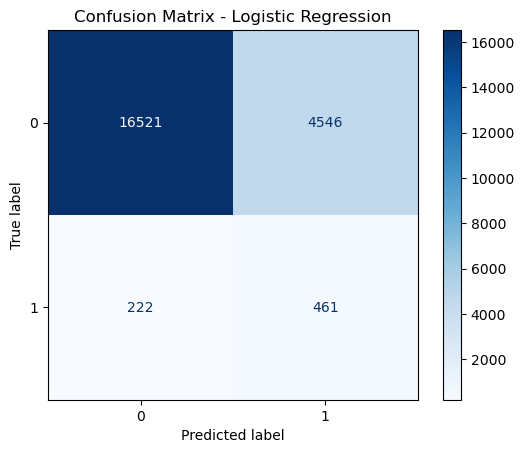

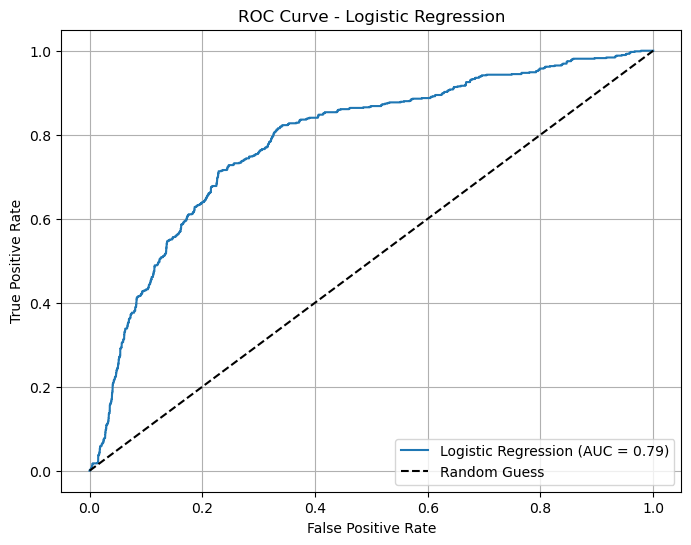

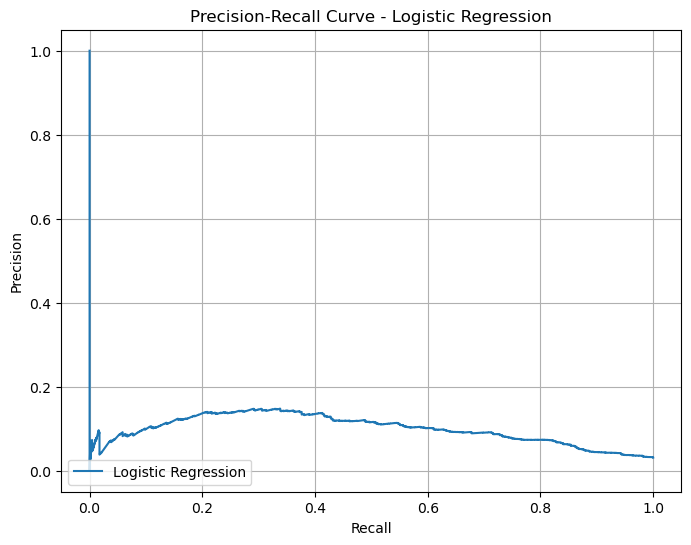

In [181]:
# Full Code: Cleaning Feature Names, Re-training, and Visualizing Logistic Regression Model

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

# Step 1: Clean Feature Names
def clean_column_names(df):
    return df.columns.str.replace(r"[^A-Za-z0-9_]", "", regex=True)

X_train_balanced.columns = clean_column_names(X_train_balanced)
X_test.columns = clean_column_names(X_test)

# Step 2: Re-Train Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_balanced, y_train_balanced)

# Step 3: Predictions and Evaluation
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Step 4: Visualizations

# 4.1 Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 4.2 ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc_score = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 4.3 Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# # # Gradient Boosting

In [18]:
# Import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the original test set
y_pred_gb = gb_model.predict(X_test)

# Evaluation Metrics for Gradient Boosting Classifier
print("Gradient Boosting Classifier Performance:")
print(classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     21102
           1       0.28      0.90      0.42       648

    accuracy                           0.93     21750
   macro avg       0.64      0.92      0.69     21750
weighted avg       0.98      0.93      0.94     21750

Accuracy: 0.9265747126436782
Confusion Matrix:
 [[19568  1534]
 [   63   585]]


In [152]:
# Check feature name consistency
print("Training feature names:", X_train_balanced.columns)
print("Test feature names:", X_test.columns)

Training feature names: Index(['CDPHId', 'CSFId', 'CSF', 'CompanyId', 'BrandName', 'PrimaryCategoryId',
       'SubCategoryId', 'CasId', 'ChemicalId', 'PrimaryCategory_babyproducts',
       ...
       'SubCategory_skintonermakingacosmeticclaim',
       'SubCategory_spraysexcludingfragrances',
       'SubCategory_sunscreenmakingacosmeticclaim',
       'SubCategory_suntanenhancers', 'SubCategory_tattoosandpermanentmakeup',
       'SubCategory_teethcleaningproducts',
       'SubCategory_teethwhiteningproducts',
       'SubCategory_toiletwatereauxdetoilette',
       'SubCategory_underarmdeodorants', 'SubCategory_uvgelnailpolish'],
      dtype='object', length=111)
Test feature names: Index(['CDPHId', 'CSFId', 'CSF', 'CompanyId', 'BrandName', 'PrimaryCategoryId',
       'SubCategoryId', 'CasId', 'ChemicalId', 'PrimaryCategory_babyproducts',
       ...
       'SubCategory_skintonermakingacosmeticclaim',
       'SubCategory_spraysexcludingfragrances',
       'SubCategory_sunscreenmakingacosme

In [154]:
# Function to clean column names
def clean_column_names(df):
    return df.columns.str.replace(r"[^A-Za-z0-9_]", "", regex=True)

# Apply cleaning to both datasets
X_train_balanced.columns = clean_column_names(X_train_balanced)
X_test.columns = clean_column_names(X_test)

In [156]:
# Re-train the Gradient Boosting Classifier
gb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate performance
print("Gradient Boosting Classifier Performance:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     21067
           1       0.30      0.91      0.45       683

    accuracy                           0.93     21750
   macro avg       0.65      0.92      0.70     21750
weighted avg       0.97      0.93      0.95     21750



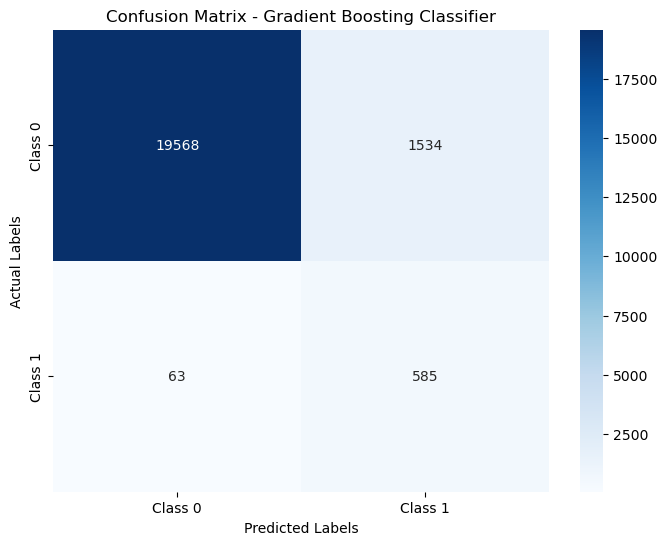

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix Data
conf_matrix = np.array([[19568, 1534], [63, 585]])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

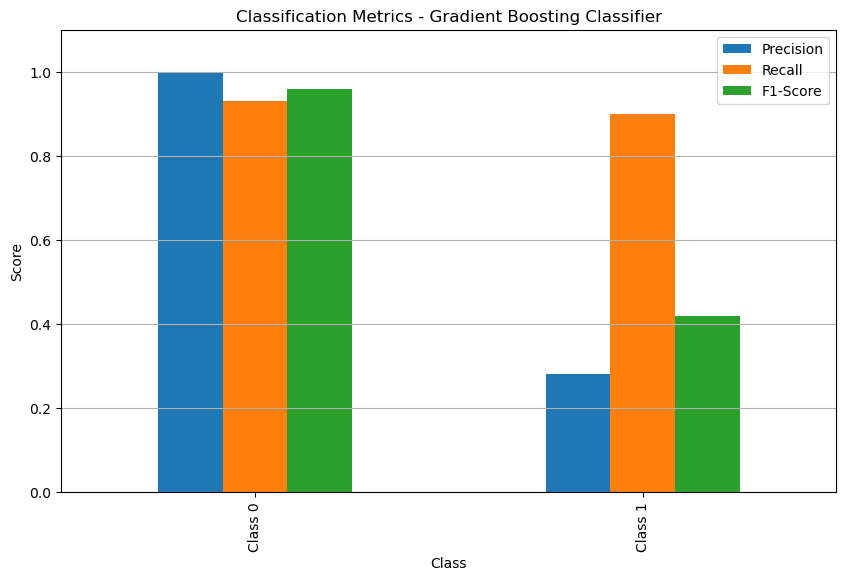

In [160]:
# Classification Metrics
import pandas as pd
import matplotlib.pyplot as plt

# Metrics from the given results
metrics_data = {
    "Class 0": {"Precision": 1.00, "Recall": 0.93, "F1-Score": 0.96},
    "Class 1": {"Precision": 0.28, "Recall": 0.90, "F1-Score": 0.42},
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data).T

# Bar Plot for Metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Classification Metrics - Gradient Boosting Classifier")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xlabel("Class")
plt.legend(loc="upper right")
plt.grid(axis='y')
plt.show()

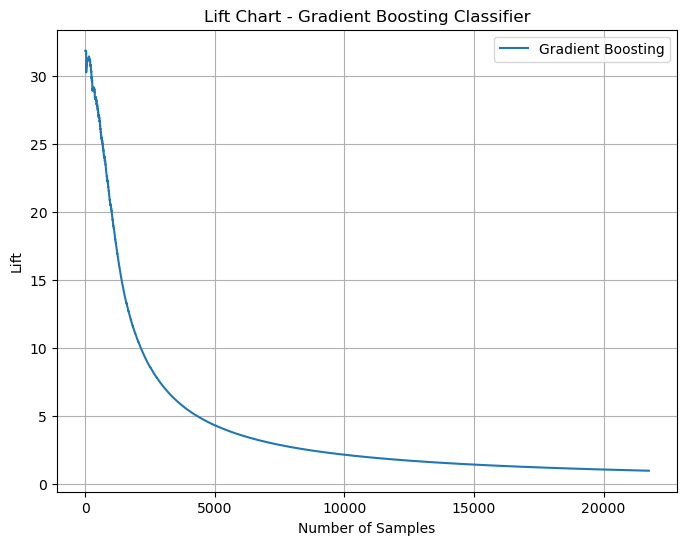

In [164]:
# Compute lift values
lift = cumulative_gain / (np.arange(1, len(cumulative_gain) + 1) / len(cumulative_gain))

# Plot Lift Chart
plt.figure(figsize=(8, 6))
plt.plot(range(len(lift)), lift, label="Gradient Boosting")
plt.xlabel("Number of Samples")
plt.ylabel("Lift")
plt.title("Lift Chart - Gradient Boosting Classifier")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [170]:
# Generate probabilities for the positive class (1)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

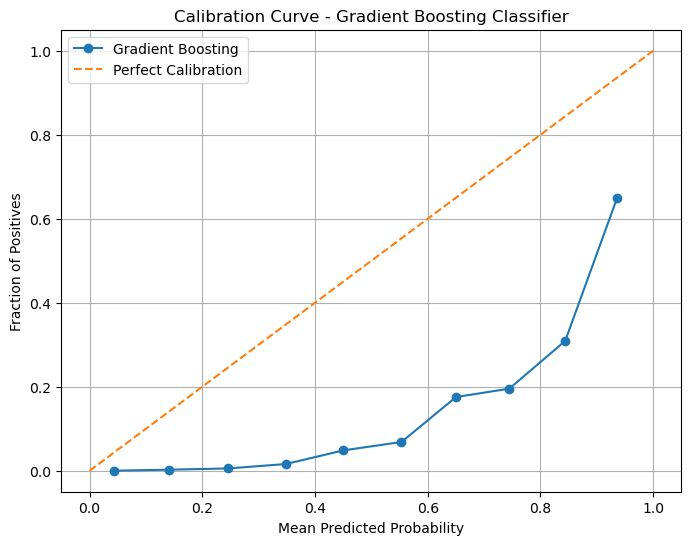

In [172]:
from sklearn.calibration import calibration_curve

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_gb, n_bins=10)

# Plot Calibration Curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Gradient Boosting")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Gradient Boosting Classifier")
plt.legend(loc="upper left")
plt.grid()
plt.show()

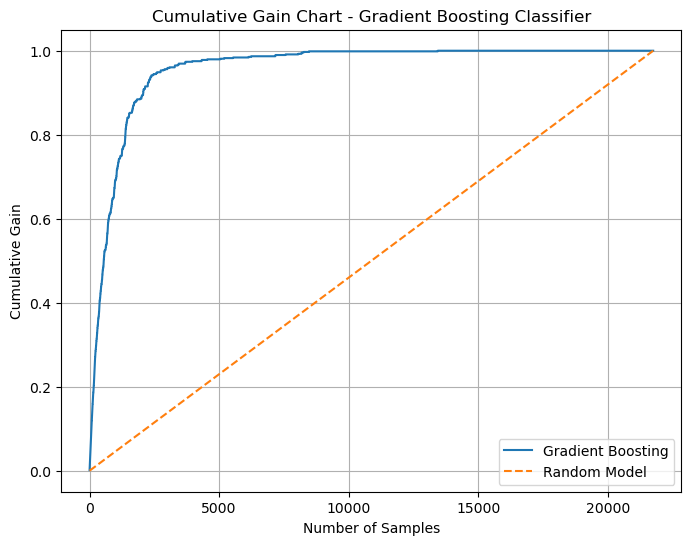

In [174]:
import numpy as np

# Generate cumulative gain data
sorted_indices = np.argsort(y_prob_gb)[::-1]
sorted_true = np.array(y_test)[sorted_indices]

cumulative_gain = np.cumsum(sorted_true) / np.sum(sorted_true)

# Plot Cumulative Gain
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_gain)), cumulative_gain, label="Gradient Boosting")
plt.plot([0, len(cumulative_gain)], [0, 1], linestyle="--", label="Random Model")
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Chart - Gradient Boosting Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

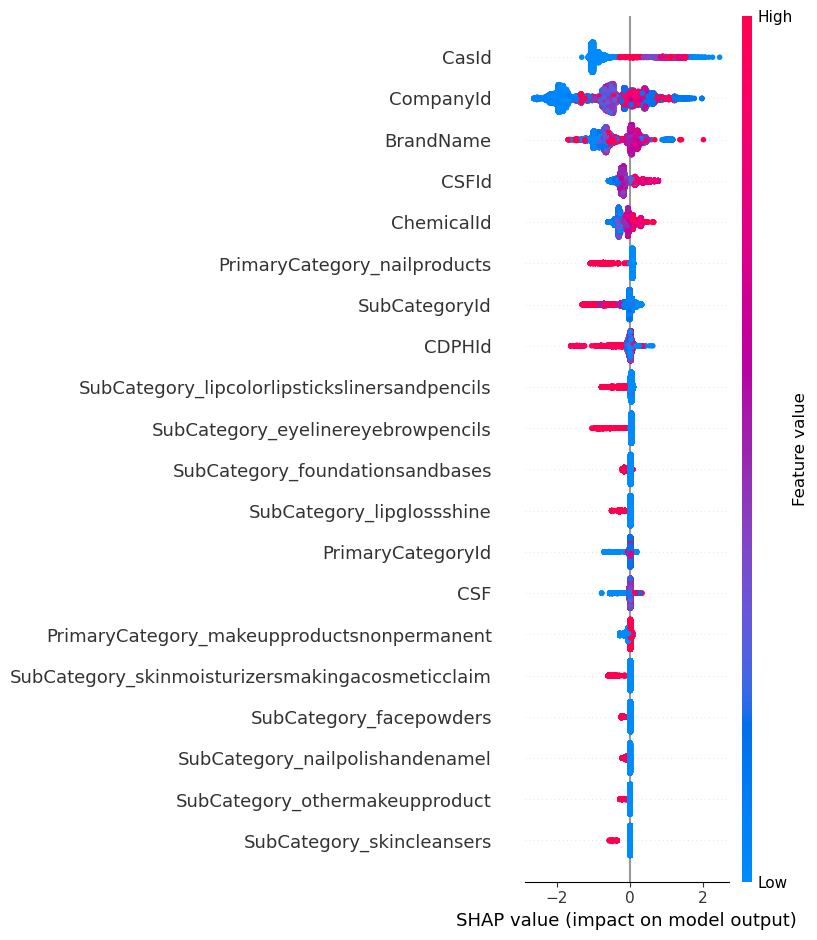

In [168]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=X_train_balanced.columns)

# Force Plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# # # Gradient Boosting Classifier Performance (after RandomizedSearchCV tuning)

In [19]:
from sklearn.model_selection import RandomizedSearchCV

# Set up a smaller parameter grid for RandomizedSearchCV to tune the Gradient Boosting Classifier
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_distributions=param_dist,
                                   n_iter=10, cv=2, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Use the best estimator to predict on the test set
best_gb_model = random_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)

# Evaluation Metrics for the Best Gradient Boosting Classifier
print("Best Gradient Boosting Classifier Performance (after RandomizedSearchCV tuning):")
print(classification_report(y_test, y_pred_best_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_gb))


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1}
Best Gradient Boosting Classifier Performance (after RandomizedSearchCV tuning):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     21102
           1       0.70      0.94      0.80       648

    accuracy                           0.99     21750
   macro avg       0.85      0.96      0.90     21750
weighted avg       0.99      0.99      0.99     21750

Accuracy: 0.9860689655172413
Confusion Matrix:
 [[20837   265]
 [   38   610]]


In [116]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [118]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=150, max_depth=7, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation Metrics for XGBoost Classifier
print("XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


C:\Users\pavan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21067
           1       0.66      0.96      0.78       683

    accuracy                           0.98     21750
   macro avg       0.83      0.97      0.89     21750
weighted avg       0.99      0.98      0.98     21750

Accuracy: 0.9833563218390805
Confusion Matrix:
 [[20733   334]
 [   28   655]]


# # # XGBoost Classifier Performance (after tuning with RandomizedSearchCV and class weights)

In [121]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Set up parameter grid for RandomizedSearchCV to tune the XGBoost Classifier
param_dist_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'scale_pos_weight': [1, 5, 10]  # Adjusting class weights for imbalance
}

# Initialize RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
                                       param_distributions=param_dist_xgb, n_iter=10, cv=2, scoring='accuracy',
                                       verbose=2, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV to the training data
random_search_xgb.fit(X_train_balanced, y_train_balanced)

# Print the best parameters found
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)

# Use the best estimator to predict on the test set
best_xgb_model = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluation Metrics for the Best XGBoost Classifier
print("Best XGBoost Classifier Performance (after tuning with RandomizedSearchCV and class weights):")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))


Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\pavan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'scale_pos_weight': 5, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Best XGBoost Classifier Performance (after tuning with RandomizedSearchCV and class weights):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     21067
           1       0.40      0.98      0.57       683

    accuracy                           0.95     21750
   macro avg       0.70      0.96      0.77     21750
weighted avg       0.98      0.95      0.96     21750

Accuracy: 0.9531494252873564
Confusion Matrix:
 [[20064  1003]
 [   16   667]]


In [123]:
# Define a function to clean column names
def clean_column_names(df):
    return df.columns.str.replace(r"[^A-Za-z0-9_]", "", regex=True)

# Apply cleaning to both datasets
X_train_balanced.columns = clean_column_names(X_train_balanced)
X_test.columns = clean_column_names(X_test)

In [125]:
# Re-train the best XGBoost model
best_xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluation Metrics
print("Best XGBoost Classifier Performance:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))

C:\Users\pavan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     21067
           1       0.40      0.98      0.57       683

    accuracy                           0.95     21750
   macro avg       0.70      0.96      0.77     21750
weighted avg       0.98      0.95      0.96     21750

Accuracy: 0.9531494252873564


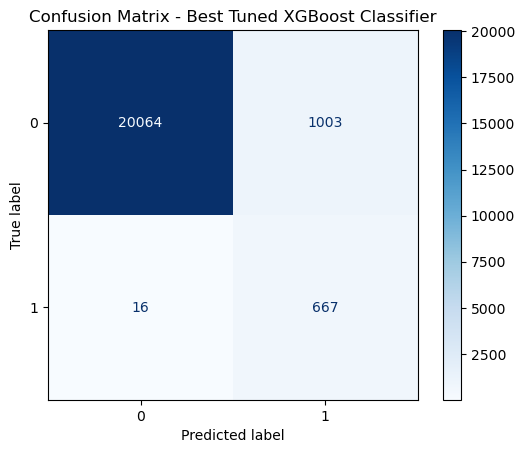

In [129]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Best Tuned XGBoost Classifier")
plt.show()

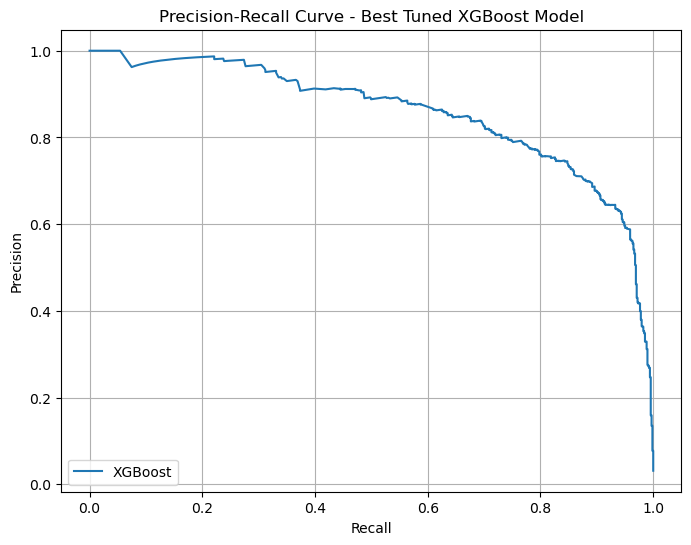

In [133]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best_xgb)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Best Tuned XGBoost Model")
plt.legend(loc="lower left")
plt.grid()
plt.show()

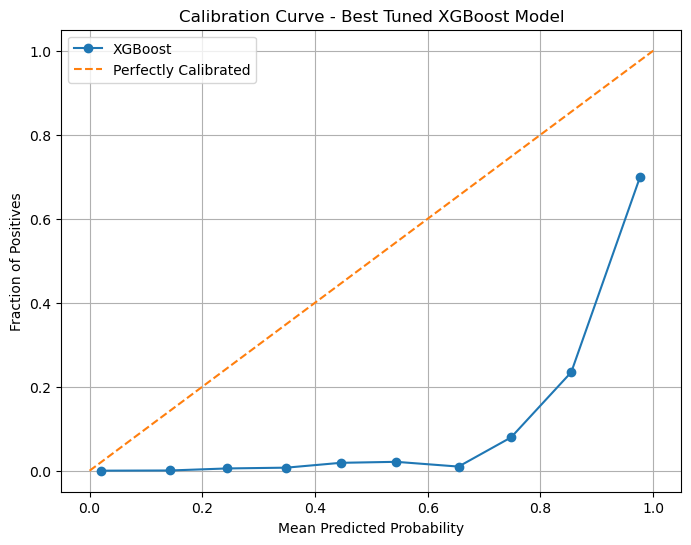

In [135]:
from sklearn.calibration import calibration_curve

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_best_xgb, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - Best Tuned XGBoost Model")
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [141]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


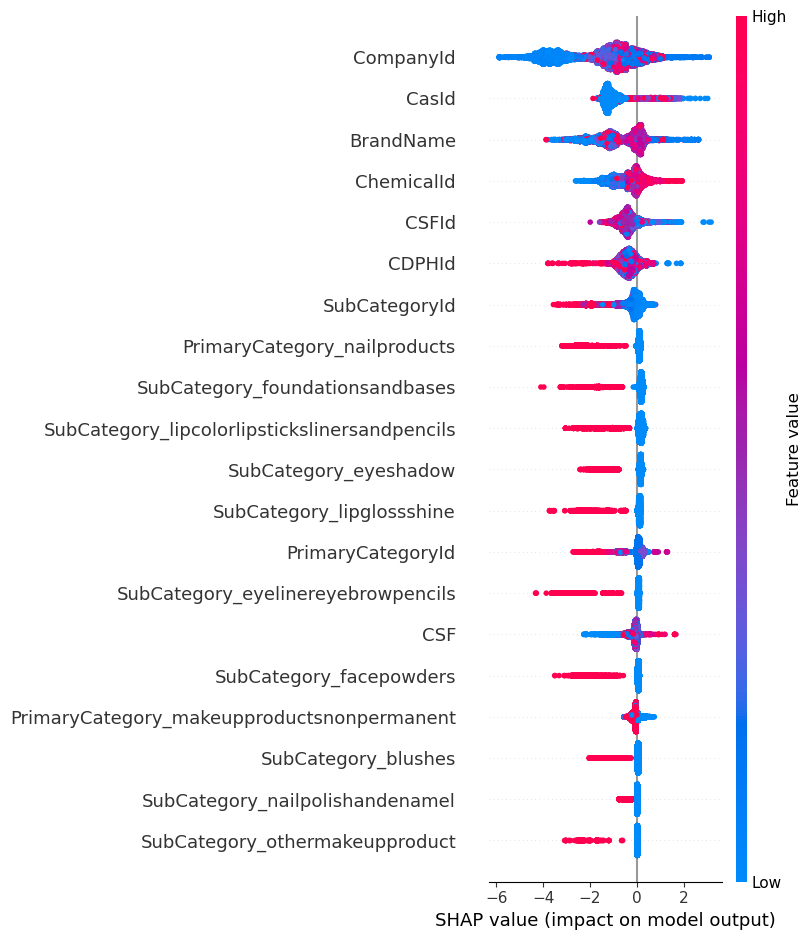

In [143]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Force Plot (for a single prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# # # lightgbm

In [23]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Clean column names to remove special characters
X_train_balanced.columns = X_train_balanced.columns.str.replace(r'[^A-Za-z0-9_]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^A-Za-z0-9_]', '', regex=True)

# Retry LightGBM after cleaning column names
from lightgbm import LGBMClassifier

# Initialize and train LightGBM Classifier
lgbm_model = LGBMClassifier(n_estimators=150, max_depth=7, learning_rate=0.1, class_weight='balanced', random_state=42)
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluation Metrics for LightGBM Classifier
print("LightGBM Classifier Performance (after column name cleaning):")
print(classification_report(y_test, y_pred_lgbm))
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


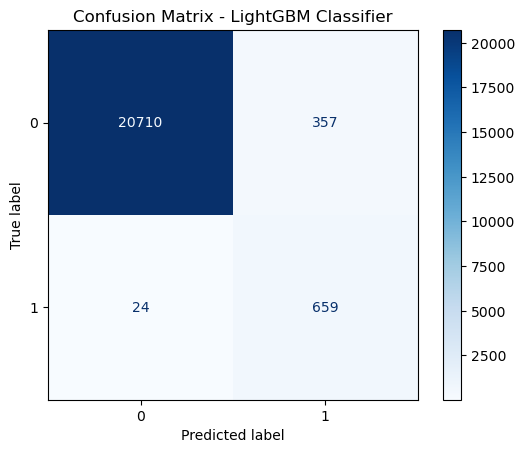

LightGBM Classifier Performance:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     21067
           1       0.04      0.06      0.05       683

    accuracy                           0.93     21750
   macro avg       0.50      0.51      0.50     21750
weighted avg       0.94      0.93      0.93     21750

Accuracy: 0.9259310344827586
ROC AUC Score: 0.9962


In [111]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(lgbm_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LightGBM Classifier")
plt.show()

# Step 2: ROC Curve Visualization
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgbm)
auc_score = roc_auc_score(y_test, y_prob_lgbm)

# Step 3: Print Classification Report and Metrics
print("LightGBM Classifier Performance:")
print(classification_report(y_test, y_pred_lgbm))
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(f"ROC AUC Score: {auc_score:.4f}")

# # # AdaBoost model

In [99]:
# Clean column names to remove special characters or spaces consistently
def clean_column_names(df):
    return df.columns.str.replace(r"[^A-Za-z0-9_]", "", regex=True)

# Apply the cleaning function to both training and test data
X_train_balanced.columns = clean_column_names(X_train_balanced)
X_test.columns = clean_column_names(X_test)

In [101]:
# Train the AdaBoost model
adaboost_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_adaboost = adaboost_model.predict(X_test)

# Evaluation Metrics
print("AdaBoost Classifier Performance:")
print(classification_report(y_test, y_pred_adaboost))
print("Accuracy:", accuracy_score(y_test, y_pred_adaboost))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adaboost))

C:\Users\pavan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     21067
           1       0.27      0.89      0.42       683

    accuracy                           0.92     21750
   macro avg       0.63      0.91      0.69     21750
weighted avg       0.97      0.92      0.94     21750

Accuracy: 0.9224367816091954
Confusion Matrix:
 [[19456  1611]
 [   76   607]]


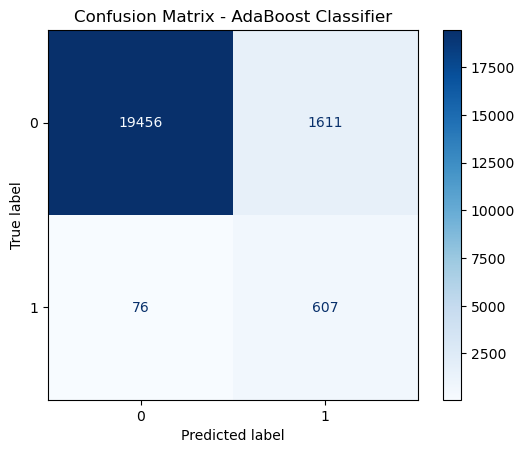

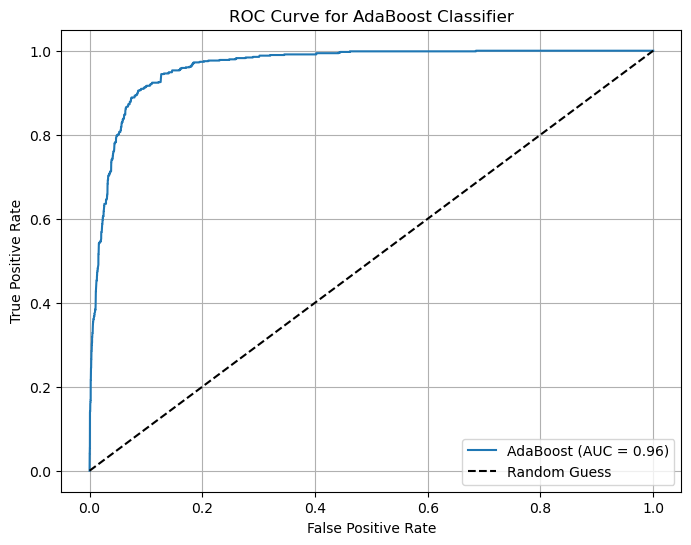

ROC AUC Score: 0.9636


In [103]:
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(adaboost_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - AdaBoost Classifier")
plt.show()

# ROC Curve Visualization
y_prob_adaboost = adaboost_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_adaboost)
auc_score = roc_auc_score(y_test, y_prob_adaboost)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AdaBoost (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"ROC AUC Score: {auc_score:.4f}")

# # # catboost

In [27]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(
    iterations=1000,           # Number of boosting iterations
    learning_rate=0.1,         # Learning rate
    depth=6,                   # Depth of the tree
    loss_function='Logloss',   # Loss function
    verbose=100,               # Print every 100 iterations
    random_seed=42             # For reproducibility
)

# Train the CatBoost model
catboost_model.fit(X_train_balanced, y_train_balanced, verbose=100)

# Predict on the test set
y_pred_catboost = catboost_model.predict(X_test)

# Evaluation Metrics for CatBoost Classifier
print("CatBoost Classifier Performance:")
print(classification_report(y_test, y_pred_catboost))
print("Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_catboost))

0:	learn: 0.6119112	total: 154ms	remaining: 2m 34s
100:	learn: 0.0931327	total: 1.88s	remaining: 16.7s
200:	learn: 0.0558010	total: 3.51s	remaining: 14s
300:	learn: 0.0419129	total: 5.12s	remaining: 11.9s
400:	learn: 0.0329717	total: 6.75s	remaining: 10.1s
500:	learn: 0.0276435	total: 8.39s	remaining: 8.35s
600:	learn: 0.0239926	total: 9.99s	remaining: 6.63s
700:	learn: 0.0212433	total: 11.6s	remaining: 4.95s
800:	learn: 0.0194834	total: 13.2s	remaining: 3.27s
900:	learn: 0.0177340	total: 14.8s	remaining: 1.62s
999:	learn: 0.0165447	total: 16.3s	remaining: 0us
CatBoost Classifier Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     21102
           1       0.77      0.94      0.85       648

    accuracy                           0.99     21750
   macro avg       0.88      0.97      0.92     21750
weighted avg       0.99      0.99      0.99     21750

Accuracy: 0.9899310344827587
Confusion Matrix:
 [[20920   182]
 [   37   

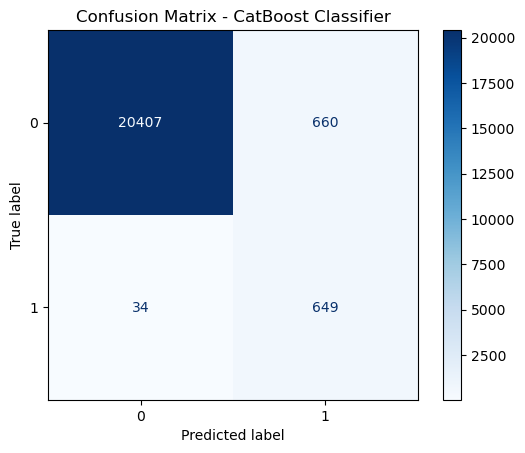

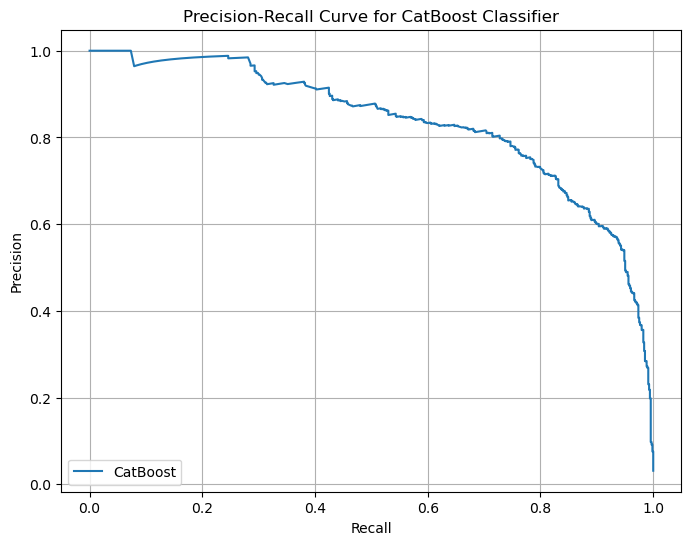

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve

# Visualizing the confusion matrix
ConfusionMatrixDisplay.from_estimator(catboost_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CatBoost Classifier")
plt.show()

# Predict probabilities for ROC curve and AUC
y_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_catboost)
auc_score = roc_auc_score(y_test, y_prob_catboost)

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_catboost)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="CatBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for CatBoost Classifier")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# # # DecisionTreeClassifier

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Train the Decision Tree model
dt_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Evaluation Metrics for Decision Tree Classifier
print("Decision Tree Classifier Performance:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Classifier Performance:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     21102
           1       0.20      0.80      0.31       648

    accuracy                           0.90     21750
   macro avg       0.59      0.85      0.63     21750
weighted avg       0.97      0.90      0.93     21750

Accuracy: 0.8962298850574713
Confusion Matrix:
 [[18975  2127]
 [  130   518]]


In [89]:
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [91]:
feature_names = X_train_balanced.columns if hasattr(X_train_balanced, 'columns') else [f"Feature {i}" for i in range(X_train_balanced.shape[1])]

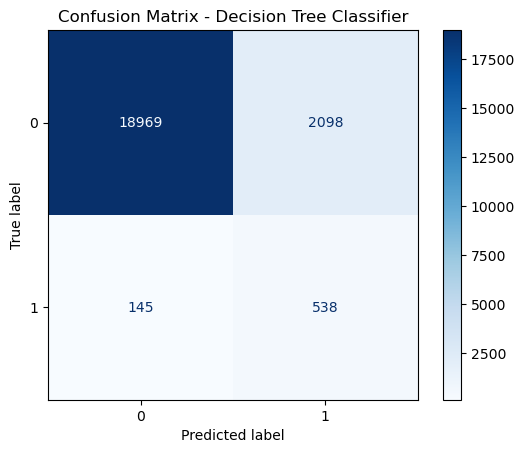

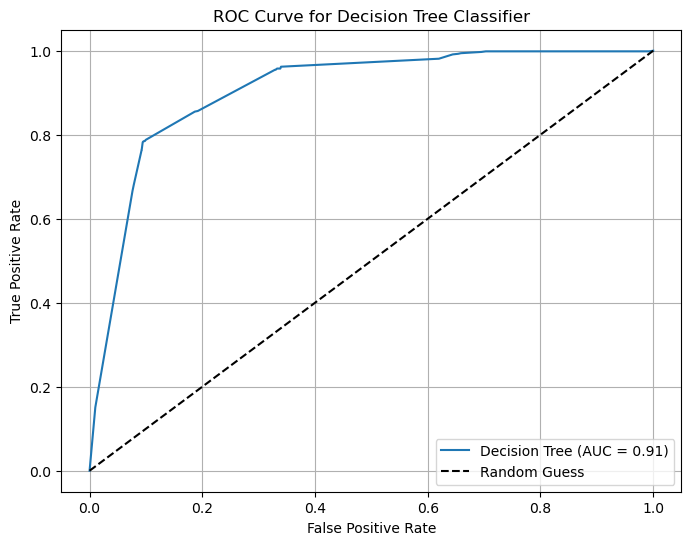

ROC AUC Score: 0.9066


In [95]:
from sklearn.tree import plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Confusion Matrix Visualization
ConfusionMatrixDisplay.from_estimator(dt_model, X_test, y_test, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

# Step 2: ROC Curve Visualization
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob_dt)
auc_score = roc_auc_score(y_test, y_prob_dt)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC score for reference
print(f"ROC AUC Score: {auc_score:.4f}")

# Algorithm Performance Comparison

In [199]:
# Exclude Random Forest from the table and sort by Accuracy (low to high)
performance_table_excluded_sorted = (
    performance_table[performance_table["Algorithm"] != "Random Forest"]
    .sort_values(by="Accuracy")
    .reset_index(drop=True)
)

# Display the table
performance_table_excluded_sorted

,Algorithm,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
0,Logistic Regression,0.6629,0.07,0.79,0.12
1,Decision Tree,0.8962,0.20,0.80,0.31
2,AdaBoost,0.9224,0.27,0.89,0.42
3,LightGBM,0.9259,0.04,0.06,0.05
4,XGBoost,0.9531,0.40,0.98,0.57
5,Gradient Boosting,0.9860,0.70,0.94,0.80
6,CatBoost,0.9899,0.77,0.94,0.85


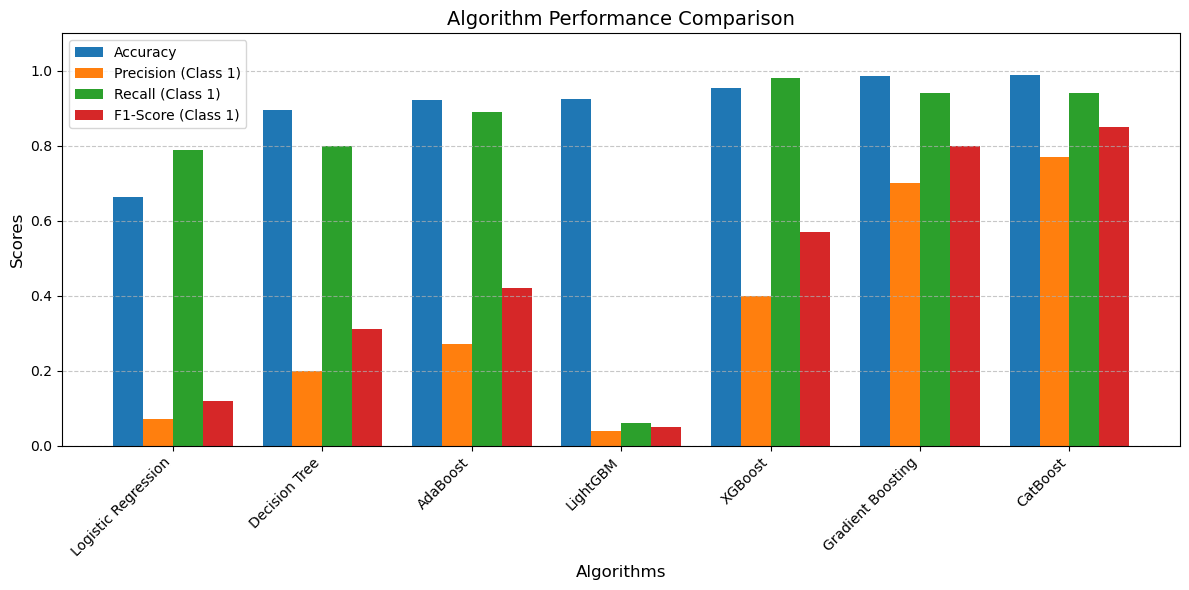

In [202]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the graph
algorithms = performance_table_excluded_sorted["Algorithm"]
accuracy = performance_table_excluded_sorted["Accuracy"]
precision = performance_table_excluded_sorted["Precision (Class 1)"]
recall = performance_table_excluded_sorted["Recall (Class 1)"]
f1_score = performance_table_excluded_sorted["F1-Score (Class 1)"]

# Bar width for grouped bar chart
bar_width = 0.2
indices = np.arange(len(algorithms))

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(indices, accuracy, width=bar_width, label="Accuracy")
plt.bar(indices + bar_width, precision, width=bar_width, label="Precision (Class 1)")
plt.bar(indices + 2 * bar_width, recall, width=bar_width, label="Recall (Class 1)")
plt.bar(indices + 3 * bar_width, f1_score, width=bar_width, label="F1-Score (Class 1)")

# Customize the plot
plt.title("Algorithm Performance Comparison", fontsize=14)
plt.xlabel("Algorithms", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.xticks(indices + 1.5 * bar_width, algorithms, rotation=45, ha="right")
plt.ylim(0, 1.1)
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\pavan\AppData\Local\Temp\ipykernel_992\1098210751.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


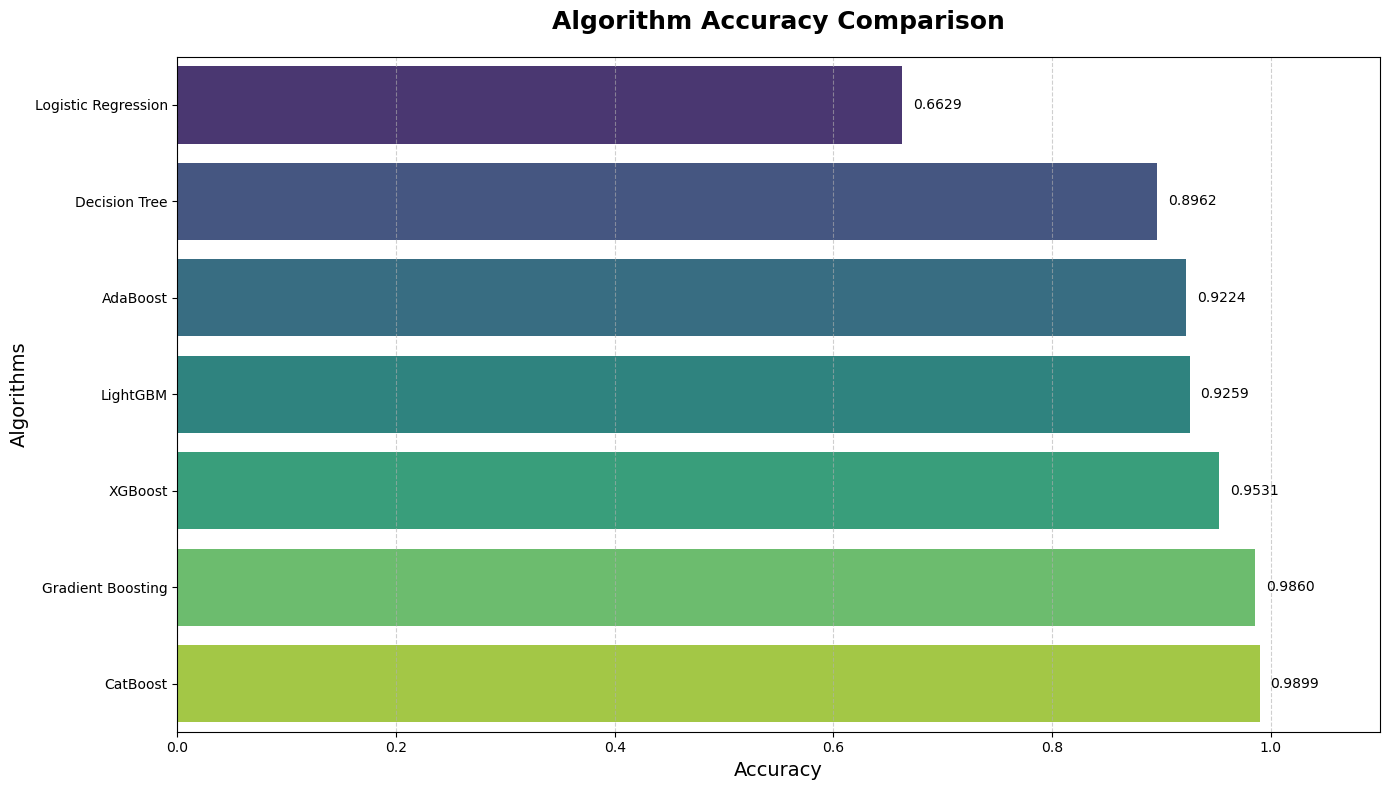

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
algorithms = performance_table_excluded_sorted["Algorithm"]
accuracy = performance_table_excluded_sorted["Accuracy"]

# Initialize the plot
plt.figure(figsize=(14, 8))

# Horizontal bar chart with custom colors
sns.barplot(
    x=accuracy,
    y=algorithms,
    palette="viridis",  # Gradient color scheme
    orient="h"
)

# Add accuracy values at the end of each bar
for index, value in enumerate(accuracy):
    plt.text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10, color="black")

# Add title and axis labels
plt.title("Algorithm Accuracy Comparison", fontsize=18, weight="bold", pad=20)
plt.xlabel("Accuracy", fontsize=14)
plt.ylabel("Algorithms", fontsize=14)
plt.xlim(0, 1.1)

# Add a grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()